**Upload Custom Image**

To evaluate our model on a real-world example, we upload an image file directly from our local device. The following command opens a file dialog in Colab, allowing us to choose an image to test:

In [17]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"basmalamohamedfarouk","key":"4eba8ba614cbf6e3a4333cce813185a1"}'}

**Setting Up Kaggle API Access**

To download datasets directly from Kaggle, we first need to configure access using the Kaggle API. This requires uploading your personal kaggle.json file (which contains your API credentials).

In [18]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle package
!pip install -q kaggle


**Downloading and Extracting CIFAKE**

We use the Kaggle API to download the CIFAKE dataset, which contains both real and AI-generated facial images. After downloading, we extract the data into a local cifake directory, preparing it for preprocessing and model training.

In [19]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip -d cifake

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace cifake/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Preparing the Data with Augmentation**

Before feeding images into our model, we need to preprocess and augment them to improve generalization. We use TensorFlow’s ImageDataGenerator to:

Rescale pixel values from [0, 255] to [0, 1] for better model stability.

Split the dataset into 80% training and 20% validation.

Apply augmentations like horizontal flips, random zooms, and rotations up to 20 degrees to increase variability.

We then create two data generators, one for training and one for validation, both loading images from the cifake/train directory resized to 224x224 pixels and organized by class. This setup ensures our model sees diverse examples and can generalize well to unseen data.



In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20,
)

train_generator = train_datagen.flow_from_directory(
    'cifake/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'cifake/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


**Visualizing Sample Images After Preprocessing**

To get a glimpse of what our model will actually see during training, we take a batch of images from the training generator and display them.

Each image is already:

Rescaled and augmented (flipped, zoomed, rotated),

Resized to 224x224 pixels,

Labeled as either "real" or "fake" based on the folder structure.

This visualization helps us verify the augmentation effects and confirm the labels before training begins, giving us confidence that the data pipeline is working as intended.

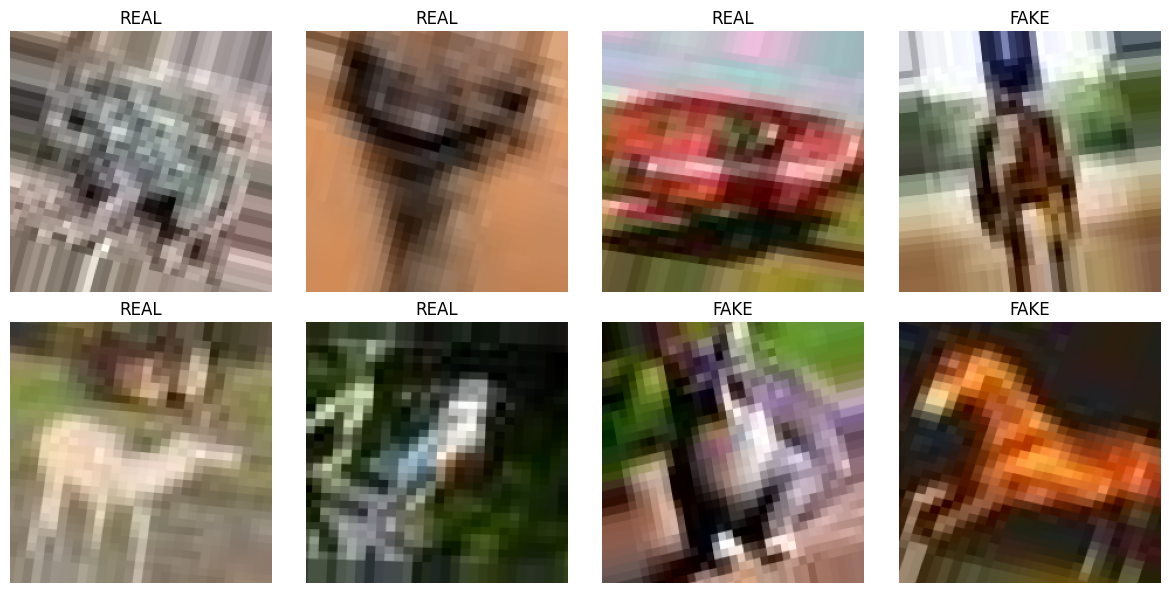

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Reverse mapping: from index (0, 1) to class name ("real", "fake")
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Get one batch of images and labels
images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])

    # Convert one-hot encoded label to class index
    label_index = np.argmax(labels[i])
    label_name = index_to_class[label_index]

    plt.title(label_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


**Building and Training a MobileNetV2-Based Classifier**

To tackle the challenge of distinguishing real from AI-generated faces, we leverage transfer learning with MobileNetV2, a lightweight yet powerful convolutional neural network pretrained on ImageNet.

We use the pretrained MobileNetV2 without its top layers, freezing its weights initially to retain learned features.

On top of the base, we add:

A global average pooling layer to reduce feature maps,

A dense layer with 128 neurons and ReLU activation to learn complex patterns,

A final softmax output layer with 2 neurons for binary classification (real vs fake).

We compile the model with the Adam optimizer and categorical cross-entropy loss suitable for multi-class classification.

To make training efficient and robust, we include callbacks:

ModelCheckpoint saves the best model based on validation accuracy,

EarlyStopping halts training if validation loss stops improving, avoiding overfitting.

Finally, we train for up to 8 epochs using our augmented data generators, validating performance along the way.

In [23]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('mobilenet_best.h5', save_best_only=True, monitor='val_accuracy', verbose=1)
early_stop = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=8,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8258 - loss: 0.3846
Epoch 1: val_accuracy improved from -inf to 0.87290, saving model to mobilenet_best.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1174s 465ms/step - accuracy: 0.8258 - loss: 0.3846 - val_accuracy: 0.8729 - val_loss: 0.2944
Epoch 2/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8714 - loss: 0.3013
Epoch 2: val_accuracy improved from 0.87290 to 0.88140, saving model to mobilenet_best.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1195s 478ms/step - accuracy: 0.8714 - loss: 0.3013 - val_accuracy: 0.8814 - val_loss: 0.2761
Epoch 3/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8773 - loss: 0.2889
Epoch 3: val_accuracy did not improve from 0.88140
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1182s 473ms/step - accuracy: 0.8773 - loss: 0.2889 - val_accuracy: 0.8798 - val_loss: 0.2854
Epoch 4/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8837 - loss: 0.2739
Epoch 4: val_accuracy improved from 0.88140 to 0.88895, saving model to mobilenet_best.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1185s 474ms/step - accuracy: 0.8837 - loss: 0.2739 - val_accuracy: 0.8889 - val_loss: 0.2593
Epoch 5/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8902 - loss: 0.2648
Epoch 5: val_accuracy improved from 0.88895 to 0.89125, saving model to mobilenet_best.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1202s 481ms/step - accuracy: 0.8902 - loss: 0.2648 - val_accuracy: 0.8913 - val_loss: 0.2580
Epoch 6/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8919 - loss: 0.2576
Epoch 6: val_accuracy improved from 0.89125 to 0.89910, saving model to mobilenet_best.h5


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1198s 479ms/step - accuracy: 0.8919 - loss: 0.2576 - val_accuracy: 0.8991 - val_loss: 0.2469
Epoch 7/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8938 - loss: 0.2561
Epoch 7: val_accuracy did not improve from 0.89910
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1195s 478ms/step - accuracy: 0.8938 - loss: 0.2561 - val_accuracy: 0.8929 - val_loss: 0.2574
Epoch 8/8
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8927 - loss: 0.2559
Epoch 8: val_accuracy did not improve from 0.89910
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1193s 477ms/step - accuracy: 0.8927 - loss: 0.2559 - val_accuracy: 0.8985 - val_loss: 0.2431


**Visualizing Training Progress**

To understand how well our model is learning, we plot the training and validation loss and accuracy curves over epochs.

The loss curves help us see if the model is minimizing errors and whether it’s overfitting (validation loss diverging from training loss).

The accuracy curves show improvements in correctly classifying images during training and validation.

By examining these plots, we can assess model performance, diagnose issues like overfitting or underfitting, and decide if further training or tuning is needed.

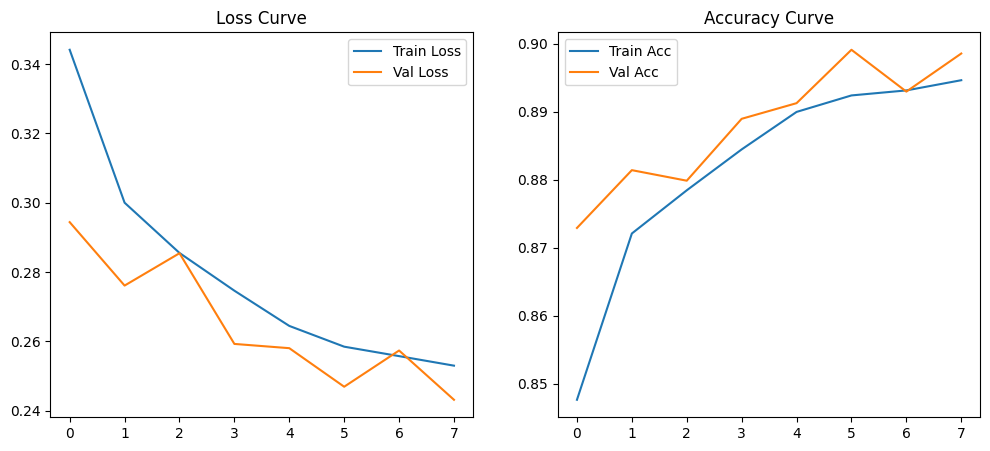

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend(); plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend(); plt.title("Accuracy Curve")
plt.show()

**Evaluating Model Performance with a Confusion Matrix**

To gain deeper insight into our model’s predictions, we compute and visualize a confusion matrix on the validation set.

We first reset the validation data generator to ensure predictions align with true labels.

The model outputs predicted probabilities, which we convert to predicted classes.

The confusion matrix compares these predictions to the actual labels, showing counts of:

True Positives and True Negatives (correct predictions),

False Positives and False Negatives (errors).

This matrix helps us identify which classes are often confused and evaluate model strengths and weaknesses beyond overall accuracy.

625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 377ms/step


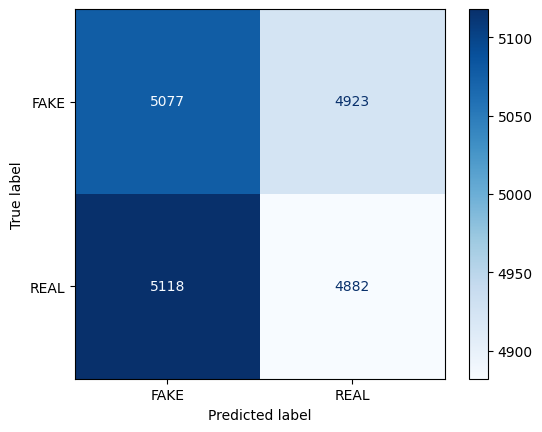

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

val_generator.reset()
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)